In [1]:
import networkx as nx
import random
from random_graph import RandomGraphBuilder
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
import copy
import dataclasses
from dataclasses import dataclass
from typing import Optional

@dataclass
class RamseyState:
    graph: nx.Graph
    ignored_nodes: set[int]
    query_node: Optional[int]
    clique: set[int]
    independent: set[int]
    neighbors: set[int]
    non_neighbors: set[int]
    c1: set[int]
    c2: set[int]
    i1: set[int]
    i2: set[int]

    @property
    def nodes(self):
        return self.graph.nodes - self.ignored_nodes
    
    def adj(self, v):
        if v in self.ignored_nodes:
            raise ValueError(f"Node {v} is not in present node set")
        
        return set(self.graph.adj[v]) - (self.ignored_nodes | {v})
    
    def recurse(self):
        new_ignore = self.ignored_nodes | {self.query_node}
        baseline = dataclasses.replace(self, query_node=None, neighbors=set(), non_neighbors=set())

        ignore_non_neighbors = new_ignore | self.non_neighbors
        nb_state = dataclasses.replace(copy.copy(baseline), ignored_nodes=ignore_non_neighbors)

        ignore_neighbors = new_ignore | self.neighbors
        nnb_state = dataclasses.replace(copy.copy(baseline), ignored_nodes=ignore_neighbors)

        return nb_state, nnb_state

    @classmethod
    def initial(cls, graph: nx.Graph):
        return cls(graph=graph,
            ignored_nodes=set(),
            query_node=None,
            clique=set(),
            independent=set(),
            neighbors=set(),
            non_neighbors=set(),
            c1=set(),
            c2=set(),
            i1=set(),
            i2=set())

    def __copy__(self):
        return RamseyState(graph=self.graph,
                             ignored_nodes=self.ignored_nodes.copy(),
                             query_node=self.query_node,
                             clique=self.clique.copy(),
                             independent=self.independent.copy(),
                             neighbors=self.neighbors.copy(),
                             non_neighbors=self.non_neighbors.copy(),
                             c1=self.c1.copy(),
                             c2=self.c2.copy(),
                             i1=self.i1.copy(),
                             i2=self.i2.copy())  

In [3]:
def ramsey(state: RamseyState):
    state = copy.copy(state)
    node_set = state.nodes

    if len(node_set) == 0:
        yield None
    
    else:
        yield copy.copy(state)

        v = random.choice(sorted(node_set))
        state.query_node = v

        yield copy.copy(state)

        neighbors = state.adj(v)
        non_neighbors = node_set - (neighbors | {v})

        state.neighbors |= neighbors
        state.non_neighbors |= non_neighbors
        yield copy.copy(state)

        nb, nnb = state.recurse()

        no_none = lambda g: list(filter(lambda s: s is not None, g))

        neighbor_states = no_none(ramsey(nb))
        if len(neighbor_states) > 0:
            c1 = neighbor_states[-1].clique.copy()
            i1 = neighbor_states[-1].independent.copy()
        else:
            c1 = set()
            i1 = set()

            state.c1 = c1.copy()
            state.i1 = i1.copy()

        yield from neighbor_states

        state.neighbors -= neighbors
        yield copy.copy(state)

        non_neighbor_states = no_none(ramsey(nnb))
        if len(non_neighbor_states) > 0:
            c2 = non_neighbor_states[-1].clique.copy()
            i2 = non_neighbor_states[-1].independent.copy()
        else:
            c2 = set()
            i2 = set()

            state.c2 = c2.copy()
            state.i2 = i2.copy()

        yield from non_neighbor_states

        state.non_neighbors -= non_neighbors
        yield copy.copy(state)

        c1.add(v)
        i2.add(v)

        state.c1 = c1.copy()
        state.i2 = i2.copy()

        state.query_node = None

        clique = max(c1, c2, key=len)
        independent = max(i1, i2, key=len)

        state.clique = clique
        state.independent = independent

        yield copy.copy(state)

In [4]:
IGNORED_ALPHA = .25
NORMAL_COLOR = '#ffffff'
QUERY_COLOR = '#0700ff'
NEIGHBOR_COLOR = '#ff6d00'
NON_NEIGHBOR_COLOR = '#ff00a6'
CLIQUE_COLOR = '#119e01'
INDEPENDENT_COLOR = '#00ebdb'

def update(state: RamseyState, pos, ax):
    ax.clear()
    graph = state.graph

    ignored_edges = {(x, y) for (x, y) in graph.edges() if x in state.ignored_nodes or y in state.ignored_nodes}
    active_edges = graph.edges() - ignored_edges

    nx.draw_networkx_edges(graph, edgelist=active_edges, pos=pos, ax=ax)
    nx.draw_networkx_edges(graph, edgelist=ignored_edges, pos=pos, ax=ax, alpha=IGNORED_ALPHA)

    nx.draw_networkx_labels(graph, pos=pos, ax=ax)

    query = {state.query_node} if state.query_node is not None else set()
    normal_nodes = state.graph.nodes - (state.neighbors | state.non_neighbors | state.clique | state.independent)

    colormap = [(normal_nodes, NORMAL_COLOR),
                (query, QUERY_COLOR), 
                (state.neighbors, NEIGHBOR_COLOR),
                (state.non_neighbors, NON_NEIGHBOR_COLOR),
                (state.clique, CLIQUE_COLOR),
                (state.independent, INDEPENDENT_COLOR)]
    
    for node_set, color in colormap:
        ignored = node_set & state.ignored_nodes
        active = node_set - state.ignored_nodes

        nx.draw_networkx_nodes(state.graph, pos=pos, ax=ax, nodelist=active, node_color=color, edgecolors='black')
        nx.draw_networkx_nodes(state.graph, pos=pos, ax=ax, nodelist=ignored, node_color=color, alpha=IGNORED_ALPHA, edgecolors='black')

Clique size: 7
found clique: {6, 7, 22, 30, 15}
found independent set: {0, 33, 34, 35, 11, 15, 16, 24}


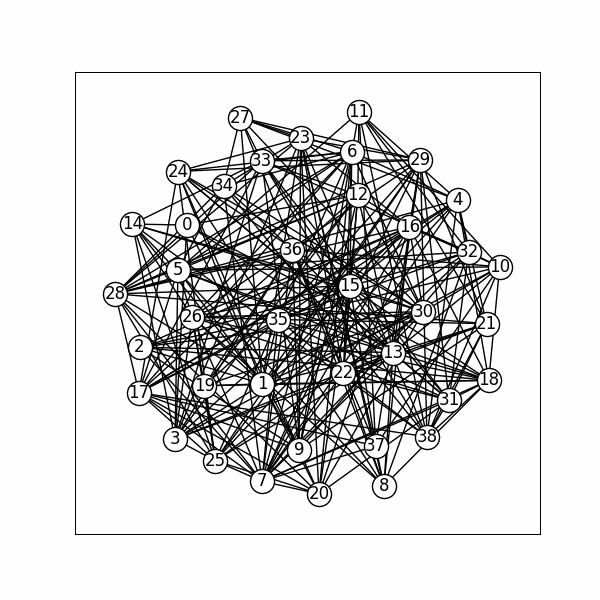

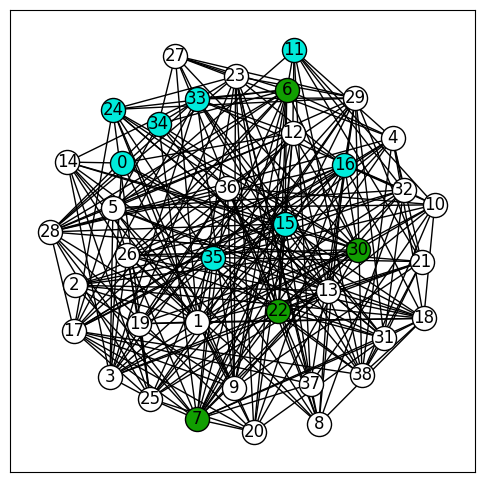

In [ ]:
number_nodes = random.choice(range(30, 41))
clique_size = random.choice(range(7, (number_nodes * 2) // 3))

builder = RandomGraphBuilder().nodes(number_nodes).clique(clique_size, False).connected().random_edges(.3).shuffle_nodes()
g = builder.build()

initial_state = RamseyState.initial(g)

states = [state for state in ramsey(initial_state) if state is not None]

print(f'Clique size: {clique_size}')
print(f'found clique: {states[-1].clique}')
print(f'found independent set: {states[-1].independent}')

# Set up the plot
fig, ax = plt.subplots(figsize=(6, 6))
pos = nx.arf_layout(g)  # Use shell_layout to avoid nodes on top of edges

FuncAnimation(fig, update, frames=states, fargs=(pos, ax), interval=1000, repeat=False).save("ramsey_animation.gif", writer='pillow', fps=.7)

Image(filename='ramsey_animation.gif')